## Import the needed package

In [1]:
# package to get the custom modules
import sys
# package for handling the environment variables
from dotenv import load_dotenv

# add the path to the custom modules
sys.path.insert(0, './../')
# load the environment variables
load_dotenv()

# package for handling the files
import os
# package for handling random numbers
from random import randint
# package for handling array
import numpy as np
# package for handling the metadata and tabular data
import pandas as pd
from itertools import chain
# the custom module for handling the data
import utilities as utils
# package for handling the machine learning model
import tensorflow as tf

c:\Users\Acer\miniconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Acer\miniconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

## Global variables

In [2]:
path_full = os.environ.get("ORI_PATH")
path_dataset_ori = os.path.join(path_full, "datasets", "splitted", "original", "test")
path_dataset_aug = os.path.join(path_full, "datasets", "splitted", "augmented", "test")
path_cdr_data = os.path.join(path_full, "data", "cdr_dataset.csv")
models_name = ["unet_model_ori", "unet_model_aug", "mnet_model_ori", "mnet_model_aug", "efnet_model_ori", "efnet_model_aug"]

## Get CDR value from the dataset

In [3]:
cdr_data = pd.read_csv(path_cdr_data)
cdr_data.head(5)

,id,label,eye_side,a_cdr,v_cdr,h_cdr
0,fff_0_111784_l_y_mask,0,l,0.340206,0.633803,0.560606
1,fff_0_111784_r_y_mask,0,r,0.300445,0.541667,0.538462
2,fff_0_113060_l_1_mask,0,l,0.473950,0.686275,0.670000
3,fff_0_113060_l_2_mask,0,l,0.516781,0.777778,0.680000
4,fff_0_113060_l_3_mask,0,l,0.491304,0.721154,0.697917


## Get the existing test image

In [4]:
# get the fundus images list from the testset
f_images_ori = [img for img in os.listdir(path_dataset_ori) if img.endswith(".jpg")]
f_images_aug = [img for img in os.listdir(path_dataset_aug) if img.endswith(".jpg")]
# merge the list
f_images = list(chain(f_images_ori, f_images_aug))
# convert the list to a dataframe
test_img = pd.DataFrame(f_images, columns=["image"])

# extract the information
test_img["id"] = test_img["image"].apply(lambda x: x.split(".")[0])         # get the id of the image
test_img = test_img[['id', 'image']]                                        # rearrange the columns order
test_img["label"] = test_img["id"].apply(lambda x: x.split("_")[1])         # get the label of the image
test_img["eye_side"] = test_img["id"].apply(lambda x: x.split("_")[3])      # get the eye side of the image
test_img.loc[~test_img.id.str.contains("aug"),"image"] = test_img.loc[~test_img.id.str.contains("aug"),
                                                                        "image"].apply(lambda x: os.path.join(path_dataset_ori, x)) # get the full path of image for original dataset
test_img.loc[test_img.id.str.contains("aug"), "image"] = test_img.loc[test_img.id.str.contains("aug"),
                                                                        "image"].apply(lambda x: os.path.join(path_dataset_aug, x)) # get the full path of image for augmented dataset
test_img.rename(columns={"image": "path"}, inplace=True)                    # rename the column image to path

# show the data information
print(f"Data length: {len(test_img)}")

Data length: 142


In [5]:
# filter the original images
test_img_ori = test_img.loc[~test_img.id.str.contains("aug")]

# reset the index
test_img_ori.reset_index(drop=True, inplace=True)

# show the data information
print(f"Data length: {len(test_img_ori)}")
# show data content
test_img_ori.drop(columns=["path"]).head(3)

Data length: 71


,id,label,eye_side
0,fff_0_115058_l_1,0,l
1,fff_0_115058_r_3,0,r
2,fff_0_121076_r_1,0,r


In [6]:
# filter the augmented images
test_img_aug = test_img.loc[test_img.id.str.contains("aug")]

# reset the index
test_img_aug.reset_index(drop=True, inplace=True)

# show the data information
print(f"Data length: {len(test_img_aug)}")
# show data content
test_img_aug.drop(columns=["path"]).head(3)

Data length: 71


,id,label,eye_side
0,fff_0_115058_l_1_aug,0,l
1,fff_0_115058_r_3_aug,0,r
2,fff_0_121076_r_1_aug,0,r


## Get the model

In [7]:
threshold = .64
rand_idx = randint(0, len(test_img_ori))

In [8]:
model = {}
for model_name in models_name:
    model[model_name] = utils.custom_load_model(os.path.join(path_full,
                                                                "data",
                                                                "model",
                                                                f"{model_name}.h5"))

## Visualize the extracted image

#### Unet

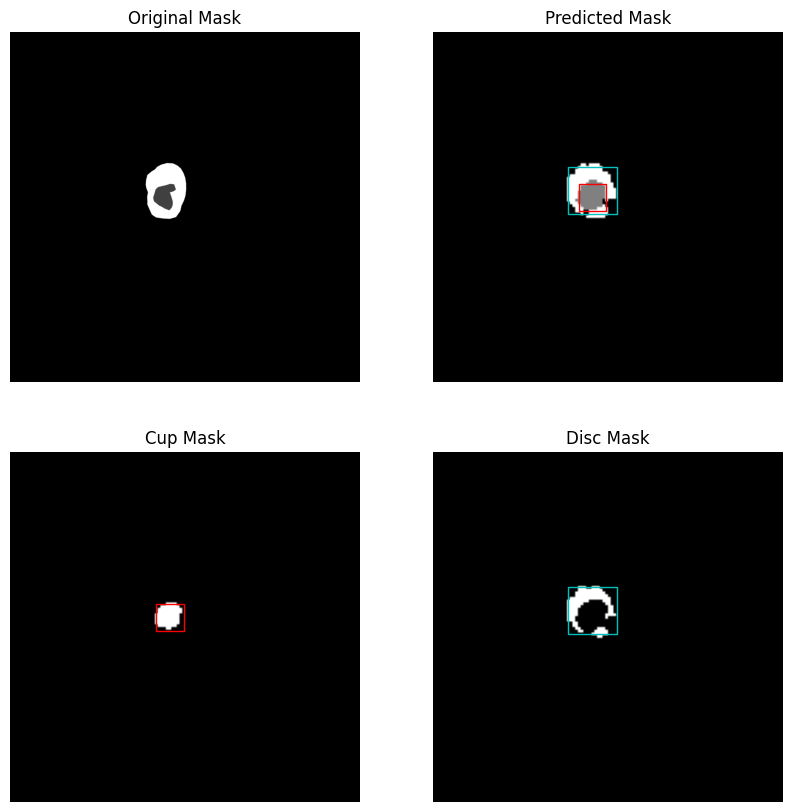

The ID of the image is fff_0_121362_l_1
Here is the CDR from ORIGINAL IMAGE values:
area_cdr: 0.3627450980392157
horizontal_cdr: 0.5555555555555556
vertical_cdr: 0.5882352941176471


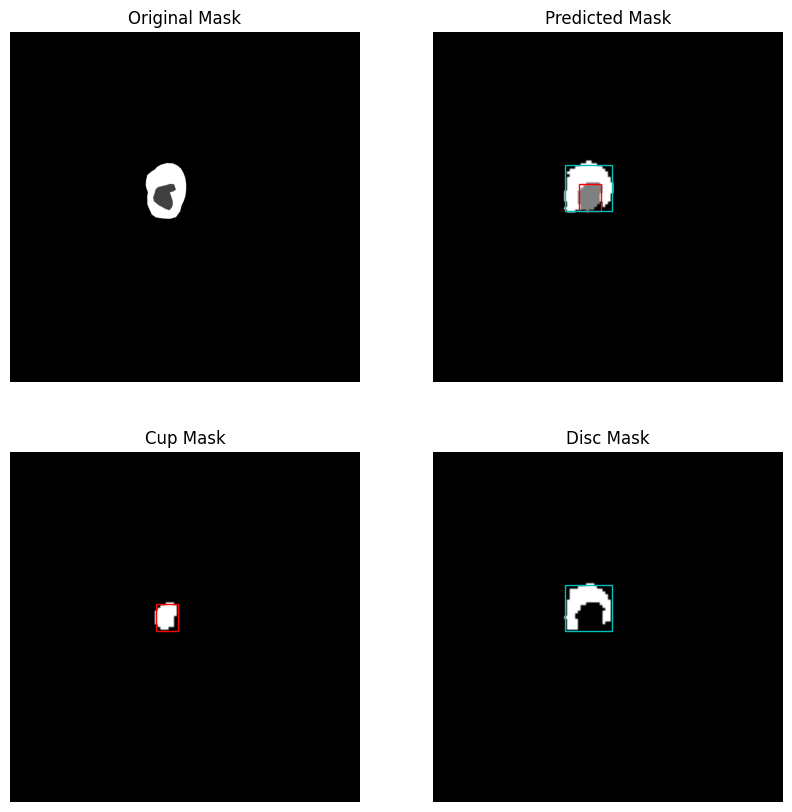

The ID of the image is fff_0_121362_l_1_aug
Here is the CDR from AUGMENTED IMAGE values:
area_cdr: 0.2995169082125604
horizontal_cdr: 0.47058823529411764
vertical_cdr: 0.5882352941176471


In [9]:
# original image
## visualize the mask image and calculate the CDR
result = utils.ev_cdr(model=model["unet_model_ori"],
                        img_path=test_img_ori.path[rand_idx],
                        mask_path=os.path.join(path_dataset_ori,
                                                f"{test_img_ori.id[rand_idx]}_mask.png"),
                        threshold=threshold,
                        visualize=True)
## show cdr result
print(f"The ID of the image is {test_img_ori.id[rand_idx]}", "Here is the CDR from ORIGINAL IMAGE values:", sep="\n")
for key, value in result.items():
    print(f"{key}: {value}")

# augmented image
## visualize the mask image and calculate the CDR
result = utils.ev_cdr(model=model["unet_model_aug"],
                        img_path=test_img_aug.path[rand_idx],
                        mask_path=os.path.join(path_dataset_aug,
                                                f"{test_img_aug.id[rand_idx].replace('aug', 'mask')}.png"),
                        threshold=threshold,
                        visualize=True)
## show cdr result
print(f"The ID of the image is {test_img_aug.id[rand_idx]}", "Here is the CDR from AUGMENTED IMAGE values:", sep="\n")
for key, value in result.items():
    print(f"{key}: {value}")

#### MobileNet

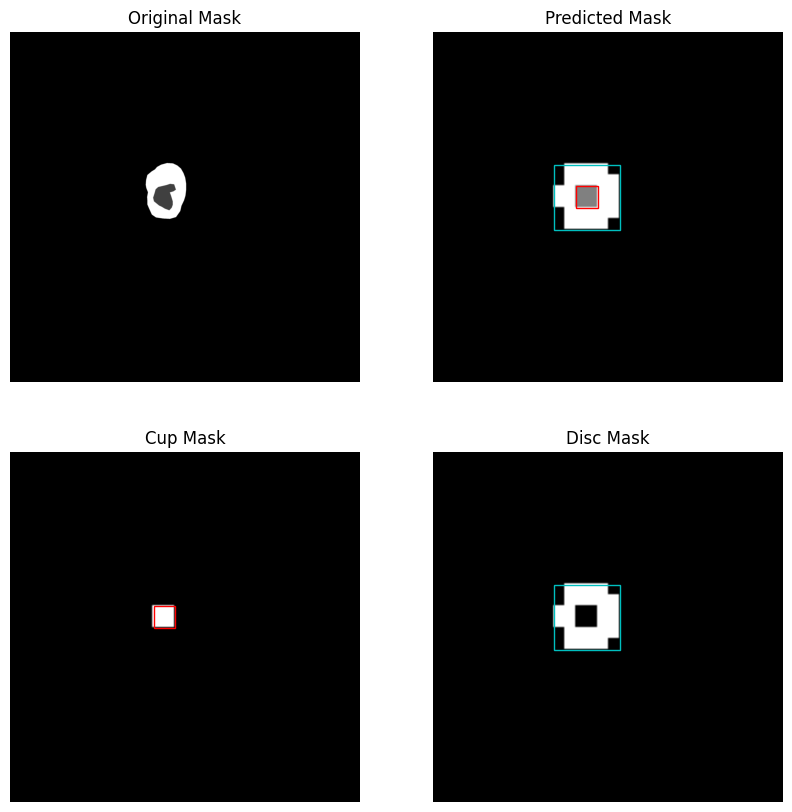

The ID of the image is fff_0_121362_l_1
Here is the CDR from ORIGINAL IMAGE values:
area_cdr: 0.13333333333333333
horizontal_cdr: 0.3333333333333333
vertical_cdr: 0.3333333333333333


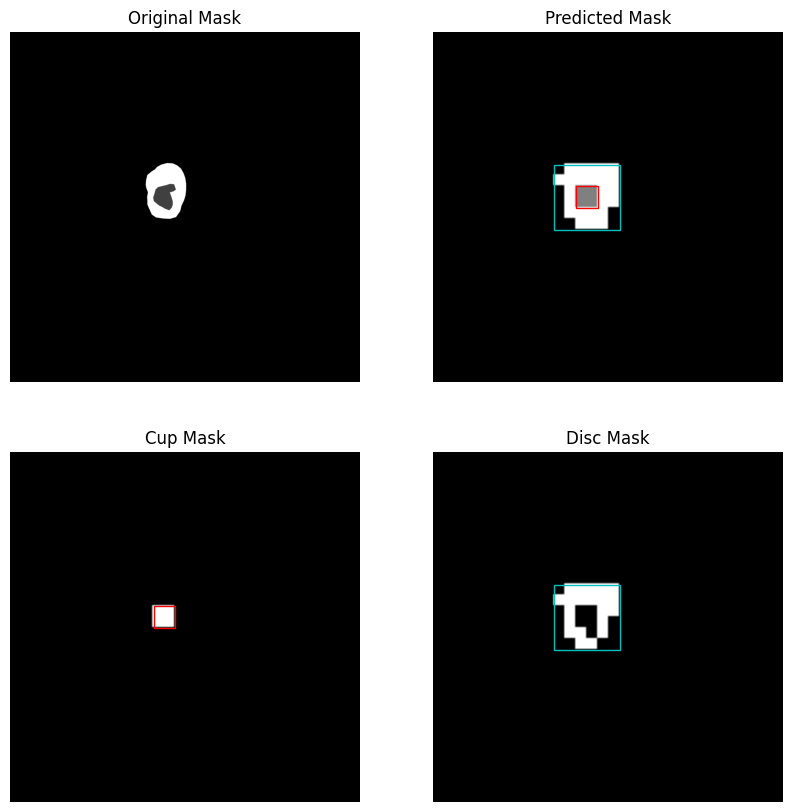

The ID of the image is fff_0_121362_l_1_aug
Here is the CDR from AUGMENTED IMAGE values:
area_cdr: 0.16
horizontal_cdr: 0.3333333333333333
vertical_cdr: 0.3333333333333333


In [10]:
# original image
## visualize the mask image and calculate the CDR
result = utils.ev_cdr(model=model["mnet_model_ori"],
                        img_path=test_img_ori.path[rand_idx],
                        mask_path=os.path.join(path_dataset_ori,
                                                f"{test_img_ori.id[rand_idx]}_mask.png"),
                        threshold=threshold,
                        visualize=True)
## show cdr result
print(f"The ID of the image is {test_img_ori.id[rand_idx]}", "Here is the CDR from ORIGINAL IMAGE values:", sep="\n")
for key, value in result.items():
    print(f"{key}: {value}")

# augmented image
## visualize the mask image and calculate the CDR
result = utils.ev_cdr(model=model["mnet_model_aug"],
                        img_path=test_img_aug.path[rand_idx],
                        mask_path=os.path.join(path_dataset_aug,
                                                f"{test_img_aug.id[rand_idx].replace('aug', 'mask')}.png"),
                        threshold=threshold,
                        visualize=True)
## show cdr result
print(f"The ID of the image is {test_img_aug.id[rand_idx]}", "Here is the CDR from AUGMENTED IMAGE values:", sep="\n")
for key, value in result.items():
    print(f"{key}: {value}")

#### EfficientNet

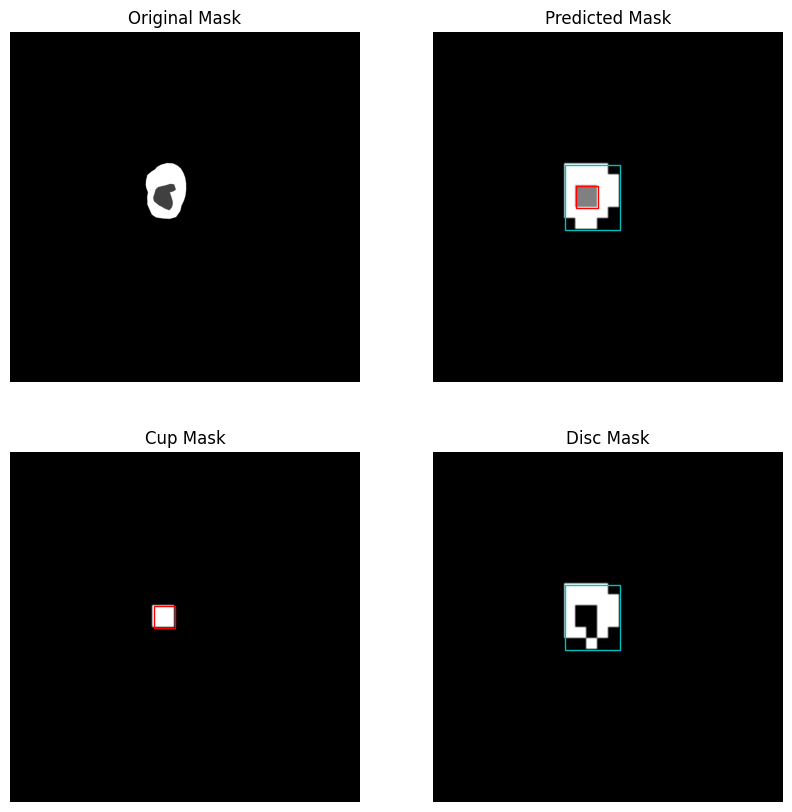

The ID of the image is fff_0_121362_l_1
Here is the CDR from ORIGINAL IMAGE values:
area_cdr: 0.17391304347826086
horizontal_cdr: 0.4
vertical_cdr: 0.3333333333333333


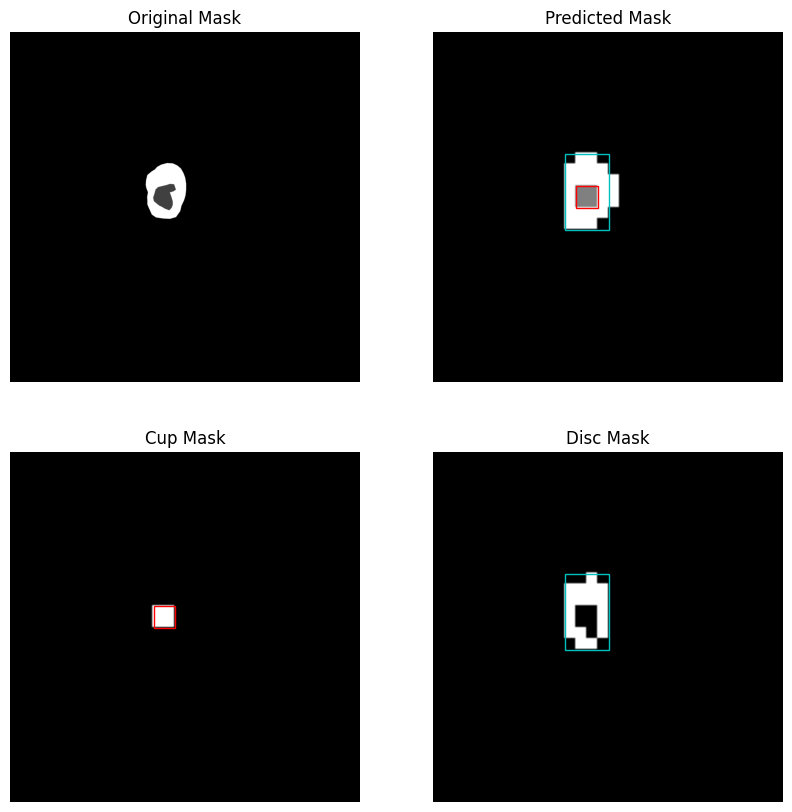

The ID of the image is fff_0_121362_l_1_aug
Here is the CDR from AUGMENTED IMAGE values:
area_cdr: 0.18181818181818182
horizontal_cdr: 0.5
vertical_cdr: 0.2857142857142857


In [11]:
# original image
## visualize the mask image and calculate the CDR
result = utils.ev_cdr(model=model["efnet_model_ori"],
                        img_path=test_img_ori.path[rand_idx],
                        mask_path=os.path.join(path_dataset_ori,
                                                f"{test_img_ori.id[rand_idx]}_mask.png"),
                        threshold=threshold,
                        visualize=True)
## show cdr result
print(f"The ID of the image is {test_img_ori.id[rand_idx]}", "Here is the CDR from ORIGINAL IMAGE values:", sep="\n")
for key, value in result.items():
    print(f"{key}: {value}")

# augmented image
## visualize the mask image and calculate the CDR
result = utils.ev_cdr(model=model["efnet_model_aug"],
                        img_path=test_img_aug.path[rand_idx],
                        mask_path=os.path.join(path_dataset_aug,
                                                f"{test_img_aug.id[rand_idx].replace('aug', 'mask')}.png"),
                        threshold=threshold,
                        visualize=True)
## show cdr result
print(f"The ID of the image is {test_img_aug.id[rand_idx]}", "Here is the CDR from AUGMENTED IMAGE values:", sep="\n")
for key, value in result.items():
    print(f"{key}: {value}")

## Get the CDR value from the predicted mask

### Unet

In [12]:
# create an empty dataframe to store the results
data_unet = {
    'ori':{},
    'aug':{}    
}

try:
    for i in np.linspace(.25, .8, 25):
        
        ev_cdr_unet = {
            "ori": pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"]),
            "aug": pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
        }
        threshold = round(i, 2)

        for idx, row in test_img_ori.iterrows():
            # get the cdr value
            cdr_value_ori = utils.ev_cdr(model=model["unet_model_ori"],
                                img_path=row.path,
                                mask_path=os.path.join(path_dataset_ori, f"{row.id}_mask.png"),
                                threshold=threshold)
                
                # populate the dataframe with the given cdr values
            ev_cdr_unet['ori'].loc[idx] = [row.id,
                            cdr_value_ori["area_cdr"],
                            cdr_value_ori["vertical_cdr"],
                            cdr_value_ori["horizontal_cdr"]]

            # get the CDR value for each image
        for idx, row in test_img_aug.iterrows():
                # get the cdr value    
            cdr_value_aug = utils.ev_cdr(model=model["unet_model_aug"],
                                img_path=row.path,
                                mask_path=os.path.join(path_dataset_aug,
                                                        f"{row.id}_mask.png"),
                                threshold=threshold)

            ev_cdr_unet['aug'].loc[idx] = [row.id,
                            cdr_value_aug["area_cdr"],
                            cdr_value_aug["vertical_cdr"],
                            cdr_value_aug["horizontal_cdr"]]
        
        loss_ori = utils.count_loss_cdr(cdr_data.drop(columns=["label", "eye_side"]), ev_cdr_unet['ori'])
        loss_aug = utils.count_loss_cdr(cdr_data.drop(columns=["label", "eye_side"]), ev_cdr_unet['aug'])

        data_unet['ori'][threshold] = loss_ori
        data_unet['aug'][threshold] = loss_aug

except Exception as e:
    if( type(e).__name__ == 'IndexError'):
        print("Stop looping cause list index out of range")
    else:
        print("Something wrong [Error] : ", e)
finally:
    print("Finish")

Stop looping cause list index out of range
Finish


#### Get the Loss of Predicted CDR with the dataset CDR

In [13]:
########## populate the loss dataframe ##########
# create an empty dataframe to store the results
loss_df_unet = pd.DataFrame(columns=['types', 'threshold', 'a_mse', 'a_mae', 'a_huber', 'h_mse', 'h_mae', 'h_huber', 'v_mse', 'v_mae', 'v_huber'])
# populate the dataframe with the given loss values

for types in ['ori', 'aug']:

    for item, value in data_unet[types].items():
        loss_df_unet.loc[len(loss_df_unet)] = [types,
                                               item,
                                    value['a_mse'],
                                    value['a_mae'],
                                    value['a_huber'],
                                    value['h_mse'],
                                    value['h_mae'],
                                    value['h_huber'],
                                    value['v_mse'],
                                    value['v_mae'],
                                    value['v_huber']]

# sort the dataframe by the loss value
loss_df_unet.sort_values(by="v_huber", ascending=True, inplace=True, ignore_index=True)

# show the data
loss_df_unet.head()

,types,threshold,a_mse,a_mae,a_huber,h_mse,h_mae,h_huber,v_mse,v_mae,v_huber
0,ori,0.27,0.017678,0.103207,0.008839,0.207456,0.150339,0.052989,0.146660,0.147510,0.052192
1,ori,0.25,0.018039,0.104505,0.009019,0.205763,0.147937,0.052142,0.147081,0.150133,0.052402
2,ori,0.39,0.017835,0.100905,0.008917,0.243128,0.168919,0.068000,0.283833,0.194547,0.086466
3,aug,0.75,0.016956,0.099778,0.008478,0.160449,0.144139,0.046628,0.570113,0.195276,0.098444
4,aug,0.69,0.016694,0.098875,0.008347,0.745358,0.202010,0.103352,0.750708,0.209912,0.109778


#### Get the class from predicted CDR value and real class

In [14]:
# get the best threshold and type dataset to evaluate predict result
thd, typed = loss_df_unet['threshold'].iloc[0], loss_df_unet['types'].iloc[0]

ev_cdr_unet_test = pd.DataFrame(columns=["id","a_class","v_class","h_class"])

if typed == 'ori':
        test_acc = test_img_ori
        path_dataset = path_dataset_ori
else:
        test_acc = test_img_aug
        path_dataset = path_dataset_aug

for idx, row in test_acc.iterrows():
            # get the cdr value
            cdr_value = utils.ev_cdr(model=model["unet_model_"+typed],
                                img_path=row.path,
                                mask_path=os.path.join(path_dataset, f"{row.id}_mask.png"),
                                threshold=thd)
                
                # populate the dataframe with the given cdr values
            ev_cdr_unet_test.loc[idx] = [row.id,
                            cdr_value["area_cdr"],
                            cdr_value["vertical_cdr"],
                            cdr_value["horizontal_cdr"]]

# create an empty dataframe to store the results
test_dataset_unet = pd.DataFrame(columns=list(ev_cdr_unet_test.columns) + ["real"])

# get the class by the CDR value and real label
for idx, row in ev_cdr_unet_test.iterrows():
    test_dataset_unet.loc[idx] = [row.id,
                            1 if row.a_class > .5 else 0,
                            1 if row.v_class > .5 else 0,
                            1 if row.h_class > .5 else 0,
                            row.id.split("_")[1]]

# show the data
test_dataset_unet.head(5)

,id,a_class,v_class,h_class,real
0,fff_0_115058_l_1,0,0,1,0
1,fff_0_115058_r_3,0,0,1,0
2,fff_0_121076_r_1,0,0,1,0
3,fff_0_121362_l_1,0,1,1,0
4,fff_0_121362_l_3,0,1,1,0


#### Count the accuracy of classification

In [15]:
# intiate the accuracy metric
acc = tf.keras.metrics.Accuracy()
# count the accuracy
acc.update_state(test_dataset_unet.real.astype(int).values,
                test_dataset_unet.v_class.astype(int).values)
# show the accuracy
print("Accuracy : ", round(acc.result().numpy(), 2))

Accuracy :  0.82


### MobileNet

In [16]:
# create an empty dataframe to store the results
data_mnet = {
    'ori':{},
    'aug':{}
}

try:
    for i in np.linspace(.25, .8, 25):
        
        ev_cdr_mnet = {
            "ori": pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"]),
            "aug": pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
        }
        threshold = round(i, 2)

        # get the CDR value for each image
        for idx, row in test_img_ori.iterrows():
            # get the cdr value
            cdr_value_ori = utils.ev_cdr(model=model["mnet_model_ori"],
                                img_path=row.path,
                                mask_path=os.path.join(path_dataset_ori,
                                                        f"{row.id}_mask.png"),
                                threshold=threshold)
            
            # populate the dataframe with the given cdr values
            ev_cdr_mnet['ori'].loc[idx] = [row.id,
                            cdr_value_ori["area_cdr"],
                            cdr_value_ori["vertical_cdr"],
                            cdr_value_ori["horizontal_cdr"]]
        
        for idx, row in test_img_aug.iterrows():

            cdr_value_aug = utils.ev_cdr(model=model["mnet_model_aug"],
                                img_path=row.path,
                                mask_path=os.path.join(path_dataset_aug,
                                                        f"{row.id}_mask.png"),
                                threshold=threshold)
            
            ev_cdr_mnet['aug'].loc[idx] = [row.id,
                            cdr_value_aug["area_cdr"],
                            cdr_value_aug["vertical_cdr"],
                            cdr_value_aug["horizontal_cdr"]]
            
        loss_ori = utils.count_loss_cdr(cdr_data.drop(columns=["label", "eye_side"]), ev_cdr_mnet['ori'])
        loss_aug = utils.count_loss_cdr(cdr_data.drop(columns=["label", "eye_side"]), ev_cdr_mnet['aug'])

        data_mnet['ori'][threshold] = loss_ori
        data_mnet['aug'][threshold] = loss_aug

except Exception as e:
    if( type(e).__name__ == 'IndexError'):
        print("Stop looping cause list index out of range")
    else:
        print("Something wrong [Error] : ", e)
finally:
    print("Finish")

Stop looping cause list index out of range
Finish


#### Get the Loss of Predicted CDR with the dataset CDR

In [17]:
########## populate the loss dataframe ##########
# create an empty dataframe to store the results
loss_df_mnet = pd.DataFrame(columns=['types','threshold', 'a_mse', 'a_mae', 'a_huber', 'h_mse', 'h_mae', 'h_huber', 'v_mse', 'v_mae', 'v_huber'])
# populate the dataframe with the given loss values
for types in ['ori', 'aug']:

    for item, value in data_mnet[types].items():
        loss_df_mnet.loc[len(loss_df_mnet)] = [types,
                                               item,
                                    value['a_mse'],
                                    value['a_mae'],
                                    value['a_huber'],
                                    value['h_mse'],
                                    value['h_mae'],
                                    value['h_huber'],
                                    value['v_mse'],
                                    value['v_mae'],
                                    value['v_huber']]

# sort the dataframe by the loss value
loss_df_mnet.sort_values(by="v_huber", ascending=True, inplace=True, ignore_index=True)

# show the data
loss_df_mnet.head()

,types,threshold,a_mse,a_mae,a_huber,h_mse,h_mae,h_huber,v_mse,v_mae,v_huber
0,ori,0.25,0.018579,0.091253,0.009290,0.020320,0.113030,0.010160,0.014300,0.084487,0.007150
1,ori,0.27,0.018962,0.093662,0.009481,0.020238,0.116112,0.010119,0.015354,0.088000,0.007677
2,ori,0.36,0.021919,0.103564,0.010959,0.021753,0.120728,0.010876,0.015994,0.091430,0.007997
3,ori,0.32,0.020939,0.098713,0.010470,0.020734,0.117610,0.010367,0.016102,0.090634,0.008051
4,ori,0.30,0.019821,0.096157,0.009911,0.020084,0.113962,0.010042,0.016275,0.090969,0.008137


#### Get the class from predicted CDR value and real class

In [19]:
thd, typed = loss_df_mnet['threshold'].iloc[0], loss_df_mnet['types'].iloc[0]

ev_cdr_mnet_test = pd.DataFrame(columns=["id", "a_class", "v_class", "h_class"])

if typed == "ori":
        test_acc = test_img_ori
        path_dataset = path_dataset_ori
else:
        test_acc = test_img_aug
        path_dataset = path_dataset_aug

for idx, row in test_acc.iterrows():
            # get the cdr value
            cdr_value = utils.ev_cdr(model=model["mnet_model_"+typed],
                                img_path=row.path,
                                mask_path=os.path.join(path_dataset, f"{row.id}_mask.png"),
                                threshold=thd)
                
                # populate the dataframe with the given cdr values
            ev_cdr_mnet_test.loc[idx] = [row.id,
                            cdr_value["area_cdr"],
                            cdr_value["vertical_cdr"],
                            cdr_value["horizontal_cdr"]]

# create an empty dataframe to store the results
test_dataset_mnet = pd.DataFrame(columns=list(ev_cdr_mnet_test.columns) + ["real"])

# get the class by the CDR value and real label
for idx, row in ev_cdr_mnet_test.iterrows():
    test_dataset_mnet.loc[idx] = [row.id,
                            1 if row.a_class > .5 else 0,
                            1 if row.v_class > .5 else 0,
                            1 if row.h_class > .5 else 0,
                            row.id.split("_")[1]]

# show the data
test_dataset_mnet.head(5)

,id,a_class,v_class,h_class,real
0,fff_0_115058_l_1,0,0,0,0
1,fff_0_115058_r_3,0,0,1,0
2,fff_0_121076_r_1,0,0,0,0
3,fff_0_121362_l_1,0,0,0,0
4,fff_0_121362_l_3,0,0,0,0


#### Count the accuracy of classification

In [20]:
# intiate the accuracy metric
acc = tf.keras.metrics.Accuracy()
# count the accuracy
acc.update_state(test_dataset_mnet.real.astype(int).values,
                test_dataset_mnet.v_class.astype(int).values)
# show the accuracy
print("Accuracy", round(acc.result().numpy(), 2))

Accuracy 0.76


### EfficientNet

In [21]:
# create an empty dataframe to store the results
data_efnet = {
    'ori':{},
    'aug':{}
}

try:
    for i in np.linspace(.25, .8, 25):
        ev_cdr_efnet = {
        "ori": pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"]),
        "aug": pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
    }
        threshold = round(i, 2)

        # get the CDR value for each image
        for idx, row in test_img_ori.iterrows():
            # get the cdr value
            cdr_value_ori = utils.ev_cdr(model=model["efnet_model_ori"],
                                img_path=row.path,
                                mask_path=os.path.join(path_dataset_ori,
                                                        f"{row.id}_mask.png"),
                                threshold=threshold)
            
            # populate the dataframe with the given cdr values
            ev_cdr_efnet['ori'].loc[idx] = [row.id,
                            cdr_value_ori["area_cdr"],
                            cdr_value_ori["vertical_cdr"],
                            cdr_value_ori["horizontal_cdr"]]
            
        for idx, row in test_img_aug.iterrows():

            cdr_value_aug = utils.ev_cdr(model=model["efnet_model_aug"],
                                img_path=row.path,
                                mask_path=os.path.join(path_dataset_aug,
                                                        f"{row.id}_mask.png"),
                                threshold=threshold)

            ev_cdr_efnet['aug'].loc[idx] = [row.id,
                            cdr_value_aug["area_cdr"],
                            cdr_value_aug["vertical_cdr"],
                            cdr_value_aug["horizontal_cdr"]]
            

        loss_ori = utils.count_loss_cdr(cdr_data.drop(columns=["label", "eye_side"]), ev_cdr_efnet['ori'])
        loss_aug = utils.count_loss_cdr(cdr_data.drop(columns=["label", "eye_side"]), ev_cdr_efnet['aug'])

        data_efnet['ori'][threshold] = loss_ori
        data_efnet['aug'][threshold] = loss_aug

except Exception as e:
    if( type(e).__name__ == 'IndexError'):
        print("Stop looping cause list index out of range")
    else:
        print("Something wrong [Error] : ", e)
finally:
    print("Finish")

Stop looping cause list index out of range
Finish


In [23]:
data_efnet

{'ori': {0.25: {'a_mse': 0.011259580061249467,
   'a_mae': 0.0624371906842659,
   'a_huber': 0.0056297895,
   'h_mse': 0.024468025113207514,
   'h_mae': 0.11500400514365751,
   'h_huber': 0.012234011,
   'v_mse': 0.01604912892787653,
   'v_mae': 0.0955366653440092,
   'v_huber': 0.008024564},
  0.27: {'a_mse': 0.011546098388275033,
   'a_mae': 0.06268889511555299,
   'a_huber': 0.005773049,
   'h_mse': 0.020332409543018855,
   'h_mae': 0.10989144572919975,
   'h_huber': 0.010166204,
   'v_mse': 0.014159404778121849,
   'v_mae': 0.09114954028096303,
   'v_huber': 0.007079702},
  0.3: {'a_mse': 0.011853965404200507,
   'a_mae': 0.06353604497914128,
   'a_huber': 0.0059269825,
   'h_mse': 0.2565860687375787,
   'h_mae': 0.16412035453557333,
   'h_huber': 0.060070105,
   'v_mse': 0.25757171767873743,
   'v_mae': 0.1513523525964514,
   'v_huber': 0.059872713},
  0.32: {'a_mse': 0.011677816358561558,
   'a_mae': 0.06169324317195644,
   'a_huber': 0.005838908,
   'h_mse': 0.25637562383502466,

#### Get the Loss of Predicted CDR with the dataset CDR

In [26]:
# create an empty dataframe to store the results
loss_df_efnet = pd.DataFrame(columns=['types','threshold', 'a_mse', 'a_mae', 'a_huber', 'h_mse', 'h_mae', 'h_huber', 'v_mse', 'v_mae', 'v_huber'])
# populate the dataframe with the given loss values

for types in ['ori','aug']:

    for item, value in data_efnet[types].items():
        loss_df_efnet.loc[len(loss_df_efnet)] = [types,
                                                 item,
                                    value['a_mse'],
                                    value['a_mae'],
                                    value['a_huber'],
                                    value['h_mse'],
                                    value['h_mae'],
                                    value['h_huber'],
                                    value['v_mse'],
                                    value['v_mae'],
                                    value['v_huber']]

# sort the dataframe by the loss value
loss_df_efnet.sort_values(by="v_huber", ascending=True, inplace=True, ignore_index=True)
# loss_df.sort_values(by="a_huber", ascending=True, inplace=True)

# show the data
loss_df_efnet.head()

,types,threshold,a_mse,a_mae,a_huber,h_mse,h_mae,h_huber,v_mse,v_mae,v_huber
0,ori,0.27,0.011546,0.062689,0.005773,0.020332,0.109891,0.010166,0.014159,0.091150,0.007080
1,ori,0.25,0.011260,0.062437,0.005630,0.024468,0.115004,0.012234,0.016049,0.095537,0.008025
2,aug,0.32,0.013991,0.073837,0.006996,0.034481,0.125803,0.017240,0.019217,0.096760,0.009609
3,aug,0.39,0.014611,0.078395,0.007305,0.034219,0.124520,0.017110,0.019517,0.097367,0.009758
4,aug,0.30,0.013846,0.074165,0.006923,0.033994,0.123354,0.016997,0.019523,0.097632,0.009761


#### Get the class from predicted CDR value and real class

In [27]:
# create an empty dataframe to store the results
thd, typed = loss_df_efnet['threshold'].iloc[0], loss_df_efnet['types'].iloc[0]

ev_cdr_efnet_test = pd.DataFrame(columns=["id","a_class","v_class","h_class"])

if typed == 'ori':
    test_acc = test_img_ori
    path_dataset = path_dataset_ori

else:
    test_acc = test_img_aug
    path_dataset = path_dataset_aug

for idx, row in test_acc.iterrows():
            # get the cdr value
            cdr_value = utils.ev_cdr(model=model["efnet_model_"+typed],
                                img_path=row.path,
                                mask_path=os.path.join(path_dataset, f"{row.id}_mask.png"),
                                threshold=thd)
                
                # populate the dataframe with the given cdr values
            ev_cdr_efnet_test.loc[idx] = [row.id,
                            cdr_value["area_cdr"],
                            cdr_value["vertical_cdr"],
                            cdr_value["horizontal_cdr"]]


test_dataset_efnet = pd.DataFrame(columns=list(ev_cdr_efnet_test.columns) + ["real"])

# get the class by the CDR value and real label
for idx, row in ev_cdr_efnet_test.iterrows():
    test_dataset_efnet.loc[idx] = [row.id,
                            1 if row.a_class > .5 else 0,
                            1 if row.v_class > .5 else 0,
                            1 if row.h_class > .5 else 0,
                            row.id.split("_")[1]]

# show the data
test_dataset_efnet.head(5)

,id,a_class,v_class,h_class,real
0,fff_0_115058_l_1,0,0,1,0
1,fff_0_115058_r_3,0,0,0,0
2,fff_0_121076_r_1,0,0,0,0
3,fff_0_121362_l_1,0,0,0,0
4,fff_0_121362_l_3,0,0,0,0


#### Count the accuracy of classification

In [28]:
# intiate the accuracy metric
acc = tf.keras.metrics.Accuracy()
# count the accuracy
acc.update_state(test_dataset_efnet.real.astype(int).values,
                test_dataset_efnet.v_class.astype(int).values)
# show the accuracy
print("Accuracy", round(acc.result().numpy(), 2))

Accuracy 0.76


## Dummy Code

### Get the Loss of predicted CDR with the dataset CDR

In [ ]:
########## count the loss value ##########
# initialize an empty dictionary to store the results
data = {}
# iterate over the threshold values
for i in np.linspace(.15, .8, 25):
    # round the threshold value to two decimal places
    threshold = round(i, 2)
    print(f"Threshold: {threshold}")
    # create an empty dataframe to store the results
    ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
    # get the CDR value for each image
    for idx, row in test_img.iterrows():
        # get the cdr value
        cdr_value = utils.ev_cdr(Unet_model,
                                row.path,
                                os.path.join(path_dataset,
                                            f"{row.id.replace('aug', 'mask')}.png"),
                                threshold,)
        # populate the dataframe with the given cdr values
        ev_cdr.loc[idx] = [row.id,
                        cdr_value["area_cdr"],
                        cdr_value["vertical_cdr"],
                        cdr_value["horizontal_cdr"]]
    # get the loss value
    loss = utils.count_loss_cdr(cdr_data.drop(columns=["label", "eye_side"]),
                                ev_cdr)
    # populate the dictionary with the given threshold and loss value
    data[threshold] = loss

In [ ]:
########## populate the loss dataframe ##########
# create an empty dataframe to store the results
loss_df = pd.DataFrame(columns=['threshold', 'a_mse', 'a_mae', 'a_huber', 'h_mse', 'h_mae', 'h_huber', 'v_mse', 'v_mae', 'v_huber'])
# populate the dataframe with the given loss values
for item, value in data.items():
    loss_df.loc[len(loss_df)] = [item,
                                value['a_mse'],
                                value['a_mae'],
                                value['a_huber'],
                                value['h_mse'],
                                value['h_mae'],
                                value['h_huber'],
                                value['v_mse'],
                                value['v_mae'],
                                value['v_huber']]

# sort the dataframe by the loss value
loss_df.sort_values(by="v_huber", ascending=True, inplace=True)
# loss_df.sort_values(by="a_huber", ascending=True, inplace=True)

# show the data
loss_df

### Get the CDR value with the best treshold

### Unet

In [ ]:
# create an empty dataframe
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
# get the CDR value for each image
for idx, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(Unet_model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .64,)   # set the threshold value
    # populate the dataframe with the given cdr values
    ev_cdr.loc[idx] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

#### Get the class from predicted CDR value and real class

In [ ]:
# create an empty dataframe to store the results
test_dataset = pd.DataFrame(columns=list(ev_cdr.columns) + ["real"])

# rename the columns
test_dataset.rename(columns={"a_cdr": "a_class", "v_cdr": "v_class", "h_cdr": "h_class"}, inplace=True)
# get the class by the CDR value and real label
for idx, row in ev_cdr.iterrows():
    test_dataset.loc[idx] = [row.id,
                            1 if row.a_cdr > .5 else 0,
                            1 if row.v_cdr > .5 else 0,
                            1 if row.h_cdr > .5 else 0,
                            row.id.split("_")[1]]

# show the data
test_dataset.head(5)

#### Count the accuracy of classification

In [ ]:
# intiate the accuracy metric
acc = tf.keras.metrics.Accuracy()
# count the accuracy
acc.update_state(test_dataset.real.astype(int).values,
                test_dataset.v_class.astype(int).values)
# show the accuracy
print("Accuracy", round(acc.result().numpy(), 2))

### mobileNet

In [ ]:
# create an empty dataframe
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
# get the CDR value for each image
for idx, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(MNet_model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .64,)   # set the threshold value
    # populate the dataframe with the given cdr values
    ev_cdr.loc[idx] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

#### Get the class from predicted CDR value and real class

In [ ]:
# create an empty dataframe to store the results
test_dataset = pd.DataFrame(columns=list(ev_cdr.columns) + ["real"])

# rename the columns
test_dataset.rename(columns={"a_cdr": "a_class", "v_cdr": "v_class", "h_cdr": "h_class"}, inplace=True)
# get the class by the CDR value and real label
for idx, row in ev_cdr.iterrows():
    test_dataset.loc[idx] = [row.id,
                            1 if row.a_cdr > .5 else 0,
                            1 if row.v_cdr > .5 else 0,
                            1 if row.h_cdr > .5 else 0,
                            row.id.split("_")[1]]

# show the data
test_dataset.head(5)

#### Count the accuracy of classification

In [ ]:
# intiate the accuracy metric
acc = tf.keras.metrics.Accuracy()
# count the accuracy
acc.update_state(test_dataset.real.astype(int).values,
                test_dataset.v_class.astype(int).values)
# show the accuracy
print("Accuracy", round(acc.result().numpy(), 2))

### EfficientNet

In [ ]:
# create an empty dataframe
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
# get the CDR value for each image
for idx, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(Efnet_model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .64,)   # set the threshold value
    # populate the dataframe with the given cdr values
    ev_cdr.loc[idx] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

#### Get the class from predicted CDR value and real class

In [ ]:
# create an empty dataframe to store the results
test_dataset = pd.DataFrame(columns=list(ev_cdr.columns) + ["real"])

# rename the columns
test_dataset.rename(columns={"a_cdr": "a_class", "v_cdr": "v_class", "h_cdr": "h_class"}, inplace=True)
# get the class by the CDR value and real label
for idx, row in ev_cdr.iterrows():
    test_dataset.loc[idx] = [row.id,
                            1 if row.a_cdr > .5 else 0,
                            1 if row.v_cdr > .5 else 0,
                            1 if row.h_cdr > .5 else 0,
                            row.id.split("_")[1]]

# show the data
test_dataset.head(5)

#### Count the accuracy of classification

In [ ]:
# intiate the accuracy metric
acc = tf.keras.metrics.Accuracy()
# count the accuracy
acc.update_state(test_dataset.real.astype(int).values,
                test_dataset.v_class.astype(int).values)
# show the accuracy
print("Accuracy", round(acc.result().numpy(), 2))